Here, we look at how house prices vary with area and room count and build a linear regression model.

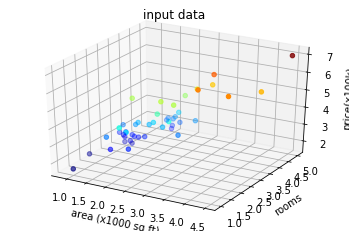

In [2]:
import numpy as np
from matplotlib import pyplot
from mpl_toolkits import mplot3d

def read_input_file(file_name):
    ip_array = np.loadtxt(file_name, delimiter=',')
    return ip_array # ip_array is a numpy array


def plot_1d_scatterplot(x_array,y_array,title,xlabel,ylabel,lim_list,marker_str,linewidth_num):
    # there should be some error handling to check if the dimensions of x and y match, let's do that later
    pyplot.plot(x_array,y_array,marker_str,linewidth = linewidth_num)
    pyplot.title(title)
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    pyplot.axis(lim_list)
    pyplot.grid(True)
    pyplot.show()
    
    
def plot_3d_scatterplot(x_array,y_array,z_array,color_str,title,xlabel,ylabel,zlabel):
    ax = pyplot.axes(projection="3d")

    ax.scatter3D(x_array, y_array, z_array, c=z_array, cmap=color_str)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    pyplot.title(title)
    pyplot.show()
    
    
def prepare_input_matrices(ip_array):
    (ip_row_count, ip_col_count) = ip_array.shape
    ip_x_array = ip_array[:,0:ip_col_count-1]
    ip_y_array = ip_array[:,ip_col_count-1:ip_col_count]

    return ip_x_array, ip_y_array


def perform_feature_normalization(ip_x_array):
    (ip_row_count, ip_col_count) = ip_x_array.shape
    norm_x_array = np.zeros(ip_x_array.shape)
    mean_x_array = np.zeros((1,ip_col_count))
    range_x_array = np.zeros((1, ip_col_count))

    for i in range(0,ip_col_count):
        curr_x_feature = ip_x_array[:,i]
        mean_x_array[0,i] = curr_x_feature.mean()
        range_x_array[0, i] = curr_x_feature.max() - curr_x_feature.min()
        norm_x_array[:,i] = (curr_x_feature - mean_x_array[0,i])/(range_x_array[0, i])

    return norm_x_array,mean_x_array,range_x_array


def create_design_array(ip_x_array):
    (ip_row_count, ip_col_count) = ip_x_array.shape
    design_array = np.ones((ip_row_count, ip_col_count+1))
    design_array[:,1::] = ip_x_array

    return design_array


def compute_model_output_array(ip_design_array, ip_parameter_array):
    ip_design_matrix = np.asmatrix(ip_design_array)
    ip_parameter_matrix = np.asmatrix(ip_parameter_array)
    model_output_matrix = ip_design_matrix*ip_parameter_matrix

    return np.asarray(model_output_matrix)


def compute_cost_function_square_mean_error(ip_design_array, ip_parameter_array, ip_y_array):
    (sample_size_count, feature_count) = ip_design_array.shape
    model_output_array = compute_model_output_array(ip_design_array, ip_parameter_array)
    error_array = model_output_array - ip_y_array
    error_matrix = np.asmatrix(error_array)

    cost_function = (error_matrix.transpose()*error_matrix)/(2*sample_size_count)
    return cost_function


def perform_gradient_descent(ip_design_array, ip_parameter_array, ip_y_array, learning_rate, init_cost, max_iter):
    (sample_size_count, feature_count) = ip_design_array.shape

    # initialize the array which holds the cost after each iteration and the number of iterations performed
    cost_array = np.zeros(max_iter)
    iter_count = 0

    # define the minimum acceptable cost
    acceptable_cost = (0.1/100)*init_cost
    curr_cost = init_cost

    while (curr_cost >= acceptable_cost) and (iter_count < max_iter):
        model_output_array = compute_model_output_array(ip_design_array, ip_parameter_array)
        error_array = model_output_array - ip_y_array

        error_matrix = np.asmatrix(error_array)
        ip_design_matrix = np.asmatrix(ip_design_array)

        ip_parameter_array = ip_parameter_array - (ip_design_matrix.transpose()*error_matrix)*(learning_rate/sample_size_count)
        curr_cost = compute_cost_function_square_mean_error(ip_design_array, ip_parameter_array, ip_y_array)
        cost_array[iter_count] = curr_cost
        iter_count += 1

    return ip_parameter_array, cost_array, iter_count


def perform_normal_equation(ip_design_array, ip_y_array):
    ip_design_matrix = np.asmatrix(ip_design_array)
    ip_y_matrix = np.asmatrix(ip_y_array)

    parameter_array = (np.linalg.pinv(ip_design_matrix.transpose()*ip_design_matrix))*ip_design_matrix.transpose()*ip_y_matrix
    normal_equation_cost = compute_cost_function_square_mean_error(ip_design_array, parameter_array, ip_y_array)

    return parameter_array,normal_equation_cost


ip_array = read_input_file("ex1data2.txt")

# separate input file into training set input and output
(ip_x_array, ip_y_array) = prepare_input_matrices(ip_array)
(training_set_sample_count, training_set_feature_count) = ip_x_array.shape

# plot the input data as a scatter plot
plot_3d_scatterplot(ip_x_array[:,0]/1000,ip_x_array[:,1],ip_y_array[:,0]/100000,"jet","input data",
                    "area (x1000 sq ft)","rooms","price(x100k)")

theta after gradient descent: 
 [[340412.65957447]
 [498696.15152346]
 [-27137.0795974 ]]
cost:  2044145113.2275307
iter count:  20000
theta after normal equation: 
 [[89597.90954361]
 [  139.21067402]
 [-8738.01911255]]
cost:  [[2.04328005e+09]]


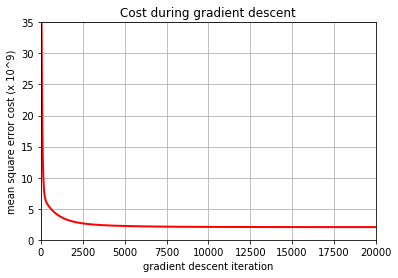

In [4]:
# perform feature normalization
(norm_x_array, mean_x_array, range_x_array) = perform_feature_normalization(ip_x_array)

# create the design array (X) and the model parameter array (theta)
ip_design_array = create_design_array(norm_x_array)
model_parameter_array = np.zeros((training_set_feature_count + 1, 1))

# compute the model output and cost with initial guess for theta
init_model_output_array = compute_model_output_array(ip_design_array, model_parameter_array)
init_cost = compute_cost_function_square_mean_error(ip_design_array, model_parameter_array, ip_y_array)
# print("initial theta: \n", model_parameter_array)
# print("initial cost: ", init_cost)

# compute the model parameters using gradient descent
learning_rate = 0.01
max_iter = 20000
(model_parameter_array_gradient_descent, gradient_descent_cost_array, iter_count) = perform_gradient_descent(
    ip_design_array, model_parameter_array, ip_y_array, learning_rate, init_cost, max_iter)

print("theta after gradient descent: \n", model_parameter_array_gradient_descent)
print("cost: ", gradient_descent_cost_array[iter_count - 1])
print("iter count: ", iter_count)

# compute the model parameters using the normal equation
# the normal equation does not require feature normalization
ip_design_array = create_design_array(ip_x_array)
(model_parameter_array_normal_equation, normal_equation_cost) = perform_normal_equation(ip_design_array, ip_y_array)

print("theta after normal equation: \n", model_parameter_array_normal_equation)
print("cost: ", normal_equation_cost)

# plot the variation of the cost function with each iteration
plot_1d_scatterplot(range(0, max_iter), gradient_descent_cost_array[0:max_iter]*(10**-9), "Cost during gradient descent",
                        "gradient descent iteration", "mean square error cost (x 10^9)",
                        [0, 20000, 0, 35], "r-", 2)